<a href="https://colab.research.google.com/github/Mark-Barbaric/IBM_Machine_Learning_Certificate/blob/classification_week5/Supervised_Machine_Learning_Classification/week5/ada_boost_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo">
</center>

# Adaptive Boosting (AdaBoost) for classification with Python

Estimated time needed: **45** minutes

## Objectives

After completing this lab you will be able to:

*   Understand  that AdaBoost is a linear combination of  𝑇 weak classifiers
*   Apply AdaBoost
*   Understand Hyperparameters selection in  AdaBoost


In this notebook, you will learn AdaBoost, short for Adaptive Boosting, is a classification algorithm; AdaBoost is actually part of a family of Boosting algorithms. Like Bagging and Random Forest (RF), AdaBoost combines the outputs of many classifiers into an ensemble, but there are some differences. In both Bagging and RF, each classifier in the ensemble is powerful but prone to overfitting. As Bagging or RF aggregate more and more classifiers, they reduce overfitting.

With AdaBoost, each Classifier usually has performance slightly better than random. This is referred to as a weak learner or weak classifier. AdaBoost combines these classifiers to get a strong classifier. Unlike Bagging and Random Forest, in AdaBoost, adding more learners can cause overfitting. As a result, AdaBoost requires Hyperparameter tuning, taking more time to train. One advantage of AdaBoost is that each classifier is smaller, so predictions are faster.


In AdaBoost, the strong classifier $H(x)$ is a linear combination of $T$ weak classifiers $h_t(x)$ and $\alpha_t$ as shown in (1). Although each classifier $h_t(x)$ appears independent, the $\alpha_t$ contains information about the error of classifiers from $h_1(x),.., h_{t-1}(x)$. As we add more classifiers, the training accuracy gets larger. What’s not so apparent in (1) is that during the training process, the values of that training sample are modified for $h_t(x)$. For a more in depth look at the theory behind Adaboost, check out <a href="https://hastie.su.domains/Papers/ESLII.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01#page=356">The Elements of Statistical Learning Data Mining, Inference, and Prediction</a>.


$H(x) = 	ext{sign}(  \sum_{t=1}^T \alpha_t h_t(x) )$ [1]


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="https://#RFvsBag">What's the difference between RF and Bagging </a></li>
        <li><a href="https://#Example">Cancer Data Example</li>
        <li><a href="https://practice/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01">Practice</a></li>

</div>
<br>
<hr>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.optimize as opt

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

In [3]:
import warnings

warnings.filterwarnings('ignore')

In [4]:
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test accuracy": accuracy_score(y_test, model.predict(X_test)),
             "train accuracy": accuracy_score(y_train, model.predict(X_train))}

In [5]:
def get_accuracy_bag(X, y, title, times=20, xlabel='Num Estimators', learning_rate=[0.2, 0.4, 0.6, 1]):
    lines_array = ['solid', '--', '-.', ':']
    n_estimators = [n for n in range(1, 200)]
    np_shape = (times, len(learning_rate), len(n_estimators))
    train_acc = np.zeros(np_shape)
    test_acc = np.zeros(np_shape)

    for n in tqdm(range(times)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        for num_trees in n_estimators:
            for j, lr in enumerate(learning_rate):
                model = AdaBoostClassifier(
                    n_estimators=num_trees + 1,
                    random_state=0,
                    learning_rate=lr
                )
                model.fit(X_train, y_train)
                accuracy = get_accuracy(X_train, X_test, y_train, y_test, model)
                train_acc[n, j, num_trees - 1] = accuracy['test accuracy']
                test_acc[n, j, num_trees - 1] = accuracy['train accuracy']

    fig, ax1 = plt.subplots()
    mean_test = test_acc.mean(axis=0)
    mean_train = train_acc.mean(axis=0)
    ax2 = ax1.twinx()

    for j, (lr, line) in enumerate(zip(learning_rate, lines_array)):
        ax1.plot(mean_train[j,:], linestyle=line, color='b', label=f"Learning rate {lr}")
        ax2.plot(mean_test[j,:], linestyle=line, color='r', label=str(lr))

    ax1.set_ylabel('Training accuracy',color='b')
    ax1.set_xlabel('No of estimators')
    ax1.legend()
    ax2.set_ylabel('Testing accuracy', color='r')
    ax2.legend()
    plt.show()

### About the dataset

We will use a telecommunications dataset for predicting customer churn. This is a historical customer dataset where each row represents one customer. The data is relatively easy to understand, and you may uncover insights you can use immediately. Typically, it is less expensive to keep customers than to acquire new ones, so the focus of this analysis is to predict the customers who will stay with the company.

This data set provides information to help you predict what behavior will help you to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.

The dataset includes information about:

*   Customers who left within the last month – the column is called Churn
*   Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
*   Customer account information – how long they have been a customer, contract, payment method, paperless billing, monthly charges, and total charges
*   Demographic info about customers – gender, age range, and if they have partners and dependents


In [6]:
churn_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/ChurnData.csv")
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


In [7]:
churn_df.dtypes

tenure      float64
age         float64
address     float64
income      float64
ed          float64
employ      float64
equip       float64
callcard    float64
wireless    float64
longmon     float64
tollmon     float64
equipmon    float64
cardmon     float64
wiremon     float64
longten     float64
tollten     float64
cardten     float64
voice       float64
pager       float64
internet    float64
callwait    float64
confer      float64
ebill       float64
loglong     float64
logtoll     float64
lninc       float64
custcat     float64
churn       float64
dtype: object

In [8]:
(churn_df.max() == 1).all()

False

In [9]:
(churn_df.min() == -1).all()

False

## Data Preprocessing

In [10]:
Y_COLUMN = 'churn'

In [11]:
churn_df[Y_COLUMN] = churn_df[Y_COLUMN].astype(int)
churn_df[Y_COLUMN].dtype

dtype('int64')

In [12]:
FEATURE_COLUMNS = ['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip', 'callcard', 'wireless', 'churn']
churn_df = churn_df[FEATURE_COLUMNS]
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,0


## Train Test Dataset

In [13]:
X=churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']]
y = churn_df[Y_COLUMN]

In [14]:
y.value_counts(normalize=True)

churn
0    0.71
1    0.29
Name: proportion, dtype: float64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Ada Boost Model Selection

In [16]:
n_estimators=5
random_state=0

In [17]:
ada_boost_classifier = AdaBoostClassifier(n_estimators=n_estimators, random_state=random_state)

If the outputs were y-1 and 1, the form of the classifier would be:

$H(x) = 	ext{sign}(  \alpha_1 h_1(x)+ \alpha_2 h_2(x)+ \alpha_3 h_3(x)+ \alpha_4 h_4(x)+ \alpha_5 h_5(x) )$

We can fit the object finding all the $\alpha_t$ $h_t(x)$ and then make a prediction:


In [18]:
model = AdaBoostClassifier(n_estimators=n_estimators,random_state=random_state)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

array([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])

In [19]:
ada_boost_classifier.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=5, random_state=0)

In [20]:
ada_boost_classifier.estimators_

[DecisionTreeClassifier(max_depth=1, random_state=209652396),
 DecisionTreeClassifier(max_depth=1, random_state=398764591),
 DecisionTreeClassifier(max_depth=1, random_state=924231285),
 DecisionTreeClassifier(max_depth=1, random_state=1478610112),
 DecisionTreeClassifier(max_depth=1, random_state=441365315)]

In [21]:
y_pred_test = ada_boost_classifier.predict(X_test)
y_pred_test

array([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])

In [22]:
accuracy_score(y_test, y_pred_test)

0.7666666666666667

In [23]:
print(get_accuracy(X_train, X_test, y_train, y_test, ada_boost_classifier))

{'test accuracy': 0.7666666666666667, 'train accuracy': 0.7642857142857142}


In [24]:
[(f"for weak classifiers {get_accuracy(X_train, X_test, y_train, y_test,  weak_classifiers)} the we get ") for i, weak_classifiers in enumerate(ada_boost_classifier.estimators_)]

["for weak classifiers {'test accuracy': 0.7, 'train accuracy': 0.7428571428571429} the we get ",
 "for weak classifiers {'test accuracy': 0.6, 'train accuracy': 0.6214285714285714} the we get ",
 "for weak classifiers {'test accuracy': 0.6333333333333333, 'train accuracy': 0.6642857142857143} the we get ",
 "for weak classifiers {'test accuracy': 0.35, 'train accuracy': 0.4642857142857143} the we get ",
 "for weak classifiers {'test accuracy': 0.43333333333333335, 'train accuracy': 0.5} the we get "]

100%|██████████| 20/20 [12:18<00:00, 36.93s/it]


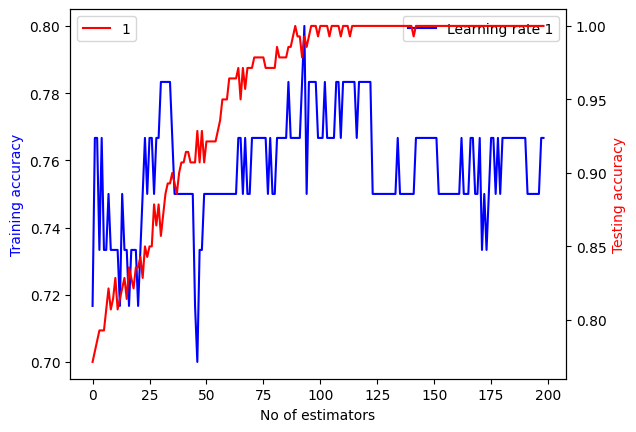

In [25]:
get_accuracy_bag(X, y, title="Training and Test Accuracy vs Weak Classifiers", learning_rate=[1], times=20, xlabel='Number Estimators')

## Changing the Base Classifier


In [26]:
from sklearn.svm import SVC

base_estimator = SVC(kernel='rbf',
                     gamma=1)
base_estimator.fit(X_train, y_train)

SVC(gamma=1)

In [27]:
print(get_accuracy(X_train, X_test, y_train, y_test, base_estimator))

{'test accuracy': 0.7666666666666667, 'train accuracy': 1.0}


In [28]:
algorithm = 'SAMME'
model = AdaBoostClassifier(
    n_estimators=5,
    base_estimator=base_estimator,
    learning_rate=1,
    algorithm=algorithm
)

In [29]:
model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', base_estimator=SVC(gamma=1),
                   learning_rate=1, n_estimators=5)

In [30]:
y_pred = model.predict(X_test)
print(get_accuracy(X_train, X_test, y_train, y_test, model))

{'test accuracy': 0.7666666666666667, 'train accuracy': 0.6857142857142857}


<h2 id="Example">Cancer Data Example</h2>

The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[[http://mlearn.ics.uci.edu/MLRepository.html](http://mlearn.ics.uci.edu/MLRepository.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01)]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

| Field name  | Description                 |
| ----------- | --------------------------- |
| ID          | Clump thickness             |
| Clump       | Clump thickness             |
| UnifSize    | Uniformity of cell size     |
| UnifShape   | Uniformity of cell shape    |
| MargAdh     | Marginal adhesion           |
| SingEpiSize | Single epithelial cell size |
| BareNuc     | Bare nuclei                 |
| BlandChrom  | Bland chromatin             |
| NormNucl    | Normal nucleoli             |
| Mit         | Mitoses                     |
| Class       | Benign or malignant         |

<br>
<br>

Let's load the dataset:


In [50]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv")
df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [58]:
mask = (df['BareNuc'] == '?')

In [63]:
df.drop(df[mask].index, inplace=True)

In [64]:
df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [65]:
FEATURE_COLUMNS = ['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']
Y_COLUMN = 'Class'

In [66]:
X = df[FEATURE_COLUMNS]
y = df[Y_COLUMN]

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [68]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.1 * (n + 1) for n in range(10)],
    'n_estimators': [2 * n + 1 for n in range(10)],
    'algorithm': ['SAMME', 'SAMME.R']
}

search = GridSearchCV(
    estimator=AdaBoostClassifier(),
    param_grid=param_grid,
    scoring='accuracy'
)
search.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4,
                                           0.5, 0.6000000000000001,
                                           0.7000000000000001, 0.8, 0.9, 1.0],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
             scoring='accuracy')

In [69]:
search.best_score_

0.9689074228523771

In [70]:
search.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 17}

In [71]:
print(get_accuracy(X_train, X_test, y_train, y_test, search))

{'test accuracy': 0.9708029197080292, 'train accuracy': 0.9725274725274725}


## Practice

Imagine that you are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug c, Drug x and y.

Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The features of this dataset are Age, Sex, Blood Pressure, and the Cholesterol of the patients, and the target is the drug that each patient responded to.

It is a sample of multiclass classifier, and you can use the training part of the dataset to build a decision tree, and then use it to predict the class of a unknown patient, or to prescribe a drug to a new patient.


In [6]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/drug200.csv", delimiter=",")
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [7]:
df.dtypes

Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
Drug            object
dtype: object

Based on the the above dtypes breakdown, will need to do some Encoding as outlined below:

- Ordinal Encoding for 'BP' and 'Cholesterol'
- Binary Encoding for 'Sex'

In [13]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

label_columns = [colname for colname in df.columns if df[colname].dtype == 'object']

In [14]:
column_transformer = ColumnTransformer(
    transformers=[
        ('label', OrdinalEncoder(), label_columns)
    ]
)

In [25]:
Y_COLUMN = 'Drug'
FEATURE_COLUMNS = [colname for colname in df.columns if colname != Y_COLUMN]

In [16]:
df[label_columns] = column_transformer.fit_transform(df[label_columns])
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0.0,0.0,0.0,25.355,4.0
1,47,1.0,1.0,0.0,13.093,2.0
2,47,1.0,1.0,0.0,10.114,2.0
3,28,0.0,2.0,0.0,7.798,3.0
4,61,0.0,1.0,0.0,18.043,4.0


In [18]:
y = df[Y_COLUMN]
X = df.drop(Y_COLUMN, axis=1)

In [19]:
y.value_counts(normalize=True)

Drug
4.0    0.455
3.0    0.270
0.0    0.115
2.0    0.080
1.0    0.080
Name: proportion, dtype: float64

Not quite an even distribution of y values, so will use Stratified Split to keep the proportions constant across training and test data.

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(stratified_shuffle_split.split(X, y))
print(f"train_index shape {train_index.shape}, test_index shape {test_index.shape}")

train_index shape (160,), test_index shape (40,)


In [33]:
X_train = X.loc[train_index, :]
X_test = X.loc[test_index, :]
y_train = y.loc[train_index]
y_test = y.loc[test_index]

In [35]:
param_grid = {
    'learning_rate': [0.1 * (n + 1) for n in range(10)],
    'n_estimators': [2 * n + 1 for n in range(10)],
    'algorithm': ['SAMME', 'SAMME.R']
}

In [36]:
model = AdaBoostClassifier()

In [40]:
from sklearn.model_selection import GridSearchCV

grid_search_cv = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3
)

In [41]:
grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4,
                                           0.5, 0.6000000000000001,
                                           0.7000000000000001, 0.8, 0.9, 1.0],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
             scoring='accuracy')

In [42]:
grid_search_cv.best_score_

0.8313533659445609

In [43]:
grid_search_cv.best_params_

{'algorithm': 'SAMME',
 'learning_rate': 0.30000000000000004,
 'n_estimators': 19}

In [44]:
print(get_accuracy(X_train, X_test, y_train, y_test, grid_search_cv))

{'test accuracy': 0.85, 'train accuracy': 0.8375}
